In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
from torchsummary import summary
import flopth
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)
os.getpid()

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


244286

In [2]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [3]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [4]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [5]:
class Attention2D(nn.Module):
    def __init__(self, max_channels, ratios, K, temperature, init_weight=True):
        super(Attention2D, self).__init__()
        assert temperature % 3 == 1
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.hidden_planes = int(max_channels * ratios) + 1
        self.fc1 = nn.Conv2d(max_channels, self.hidden_planes, 1, bias=False)
        self.fc2 = nn.Conv2d(self.hidden_planes, K, 1, bias=True)
        self.temperature = temperature
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def update_temperature(self):
        if self.temperature != 1:
            self.temperature -= 3
            print('Change temperature to:', str(self.temperature))

    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x).reshape(x.size(0), -1)
        return F.softmax(x / self.temperature, dim=1)

class DynamicSelectiveConvLayer(nn.Module):
    def __init__(self, max_channels, out_channels, kernel_size, stride=1, padding=1, bias=False, ratio=0.25, K=4, temperature=34, init_weight=True):
        super(DynamicSelectiveConvLayer, self).__init__()
        self.max_channels = max_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias_param = bias
        self.K = K
        self.attention = Attention2D(max_channels, ratio, K, temperature)

        self.weights = nn.Parameter(torch.randn(K, out_channels, max_channels, kernel_size, kernel_size), requires_grad=True)
        if bias:
            self.bias = nn.Parameter(torch.zeros(K, out_channels))
        else:
            self.register_parameter('bias', None)
        
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for i in range(self.K):
            nn.init.kaiming_uniform_(self.weights[i])

    def update_temperature(self):
        self.attention.update_temperature()

    def forward(self, x, selected_channels):
        batch_size, _, height, width = x.size()
        
        # Create a mask to select specific channels
        channel_mask = torch.zeros(self.max_channels, dtype=torch.bool, device=x.device)
        channel_indices = torch.tensor(selected_channels, dtype=torch.long, device=x.device)
        channel_mask[channel_indices] = True

        # Apply mask to input to select only the required channels
        x_selected = x[:, channel_mask, :, :]

        # Adjust the attention mechanism to match the number of selected channels
        self.attention.fc1 = nn.Conv2d(len(selected_channels), self.attention.hidden_planes, 1, bias=False).to(x.device)
        self.attention.fc2 = nn.Conv2d(self.attention.hidden_planes, self.K, 1, bias=True).to(x.device)

        # Generate dynamic weights based on attention scores
        softmax_attention = self.attention(x_selected)
        selected_in_channels = len(selected_channels)
        weight = self.weights[:, :, :selected_in_channels, :, :].reshape(self.K, -1)

        aggregate_weight = torch.mm(softmax_attention, weight).reshape(batch_size * self.out_channels, selected_in_channels, self.kernel_size, self.kernel_size)
        
        if self.bias is not None:
            aggregate_bias = torch.mm(softmax_attention, self.bias).reshape(-1)
            output = F.conv2d(x_selected.reshape(1, -1, height, width), weight=aggregate_weight, bias=aggregate_bias, stride=self.stride, padding=self.padding, groups=batch_size)
        else:
            output = F.conv2d(x_selected.reshape(1, -1, height, width), weight=aggregate_weight, bias=None, stride=self.stride, padding=self.padding, groups=batch_size)

        output = output.reshape(batch_size, self.out_channels, output.size(-2), output.size(-1))
        return output

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = DynamicSelectiveConvLayer(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, selected_channels = [0, 1, 2]):
        x = self.conv1(x, selected_channels)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [9]:
#calflops can't be used, so we can only count the #PARAMS
summary(model, input_size=(3, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1              [-1, 3, 1, 1]               0
       Attention2D-2                    [-1, 4]               0
DynamicSelectiveConvLayer-3           [-1, 64, 84, 84]               0
       BatchNorm2d-4           [-1, 64, 84, 84]             128
              ReLU-5           [-1, 64, 84, 84]               0
         MaxPool2d-6           [-1, 64, 42, 42]               0
            Conv2d-7           [-1, 64, 42, 42]          36,864
       BatchNorm2d-8           [-1, 64, 42, 42]             128
              ReLU-9           [-1, 64, 42, 42]               0
           Conv2d-10           [-1, 64, 42, 42]          36,864
      BatchNorm2d-11           [-1, 64, 42, 42]             128
             ReLU-12           [-1, 64, 42, 42]               0
       BasicBlock-13           [-1, 64, 42, 42]               0
           Conv2d-14           [

In [10]:
num_epochs = 50
early_stopping_counter = 0
best_val_loss = float('inf')
selected_channels = [0, 1, 2]  # RGB for training, can be changed as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass with dynamic channel selection
        outputs = model(inputs, selected_channels)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, selected_channels)  # Ensure dynamic channel selection is used
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    # Step the scheduler after each epoch (if using scheduler)
    # scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'part1/best_model_v3_{res}.pth')  # Save the best model
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 2:  # stops if no improvement after 3 epochs
        print("Early stopping triggered.")
        break

/home/re6125015/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 3.2772 Train Acc: 13.54% Val Loss: 3.0698 Val Acc: 18.22%
Epoch 2: Train Loss: 2.7073 Train Acc: 24.51% Val Loss: 2.5917 Val Acc: 27.78%
Epoch 3: Train Loss: 2.3612 Train Acc: 32.39% Val Loss: 2.8674 Val Acc: 25.11%
Epoch 4: Train Loss: 2.0854 Train Acc: 38.81% Val Loss: 2.3619 Val Acc: 33.33%
Epoch 5: Train Loss: 1.8556 Train Acc: 44.49% Val Loss: 2.2376 Val Acc: 36.00%
Epoch 6: Train Loss: 1.6571 Train Acc: 49.94% Val Loss: 1.8082 Val Acc: 46.00%
Epoch 7: Train Loss: 1.4836 Train Acc: 54.32% Val Loss: 1.8759 Val Acc: 44.67%
Epoch 8: Train Loss: 1.3391 Train Acc: 58.39% Val Loss: 1.7071 Val Acc: 49.11%
Epoch 9: Train Loss: 1.1963 Train Acc: 62.15% Val Loss: 1.7181 Val Acc: 51.33%
Epoch 10: Train Loss: 1.0578 Train Acc: 65.85% Val Loss: 1.6708 Val Acc: 51.33%
Epoch 11: Train Loss: 0.9288 Train Acc: 69.53% Val Loss: 1.8192 Val Acc: 50.67%
Epoch 12: Train Loss: 0.8091 Train Acc: 73.19% Val Loss: 1.7469 Val Acc: 50.89%
Epoch 13: Train Loss: 0.7103 Train Acc: 76.11% Va

In [11]:
print(best_val_loss)

1.670759300324652


In [12]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50)
model.load_state_dict(torch.load(f'part1/best_model_v3_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

ResNet(
  (conv1): DynamicSelectiveConvLayer(
    (attention): Attention2D(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (fc2): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [13]:
# Function to make predictions and optionally evaluate the model with selected channels
def predict(model, data_loader, selected_channels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            # Update the model call to include selected_channels
            outputs = model(inputs, selected_channels)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Example of using the updated predict function
selected_channels = [0, 1, 2]  #Use to inference different channel combinations (0 = Red, 1 = Green, 2 = Blue)
predictions, labels = predict(model, test_loader, selected_channels)

In [14]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 52.00%


In [15]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'part1/predict_rgb_v3_{res}.csv', index=False)

In [18]:
selected_channels = [0, 1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RG): {accuracy:.2f}%")

Accuracy on test data (RG): 4.89%


In [19]:
selected_channels = [0, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RB): {accuracy:.2f}%")

Accuracy on test data (RB): 4.00%


In [20]:
selected_channels = [1, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (GB): {accuracy:.2f}%")

Accuracy on test data (GB): 3.78%


In [21]:
selected_channels = [0]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (R): {accuracy:.2f}%")

Accuracy on test data (R): 2.89%


In [22]:
selected_channels = [1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (G): {accuracy:.2f}%")

Accuracy on test data (G): 2.00%


In [23]:
selected_channels = [2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (B): {accuracy:.2f}%")

Accuracy on test data (B): 2.44%


In [16]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.83      0.56      0.67         9
           2       0.60      0.67      0.63         9
           3       0.50      0.78      0.61         9
           4       0.73      0.89      0.80         9
           5       0.67      0.44      0.53         9
           6       1.00      0.56      0.71         9
           7       0.83      0.56      0.67         9
           8       0.23      0.33      0.27         9
           9       0.40      0.22      0.29         9
          10       0.50      0.44      0.47         9
          11       0.00      0.00      0.00         9
          12       0.80      0.44      0.57         9
          13       0.14      0.22      0.17         9
          14       0.57      0.44      0.50         9
          15       0.60      0.33      0.43         9
          16       0.31      0.44      0.36         9
    

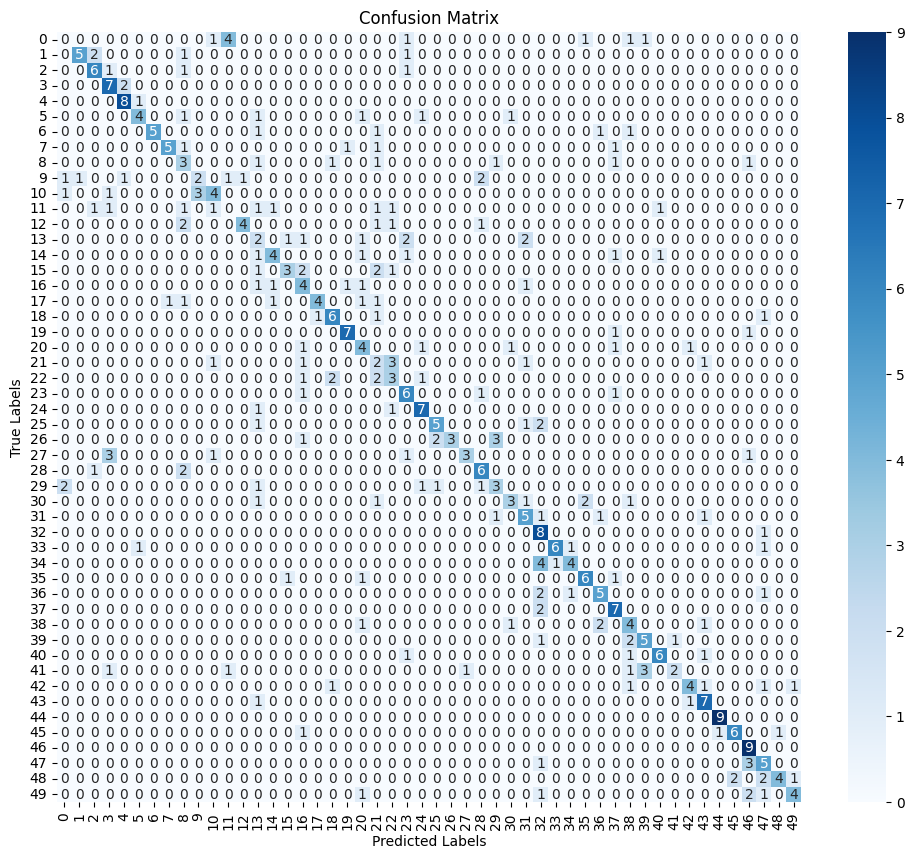

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()